In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# 1. Load and prepare data
df = pd.read_csv("indian_liver_patient.csv")
df.rename(columns={'Dataset': 'Target'}, inplace=True)

df.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Target
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


In [3]:
# 2. Convert target to binary (1=liver disease, 0=no disease)
df['Target'] = df['Target'].apply(lambda x: 0 if x == 1 else 1)

# 3. Handle categorical data (Male=1, Female=0)
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})



In [4]:
# Standardize column names
df.columns = df.columns.str.lower().str.replace(" ", "_")
df.columns


Index(['age', 'gender', 'total_bilirubin', 'direct_bilirubin',
       'alkaline_phosphotase', 'alamine_aminotransferase',
       'aspartate_aminotransferase', 'total_protiens', 'albumin',
       'albumin_and_globulin_ratio', 'target'],
      dtype='object')

In [5]:
# 4. Handle missing values with median imputation
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
df[df.columns] = imputer.fit_transform(df)



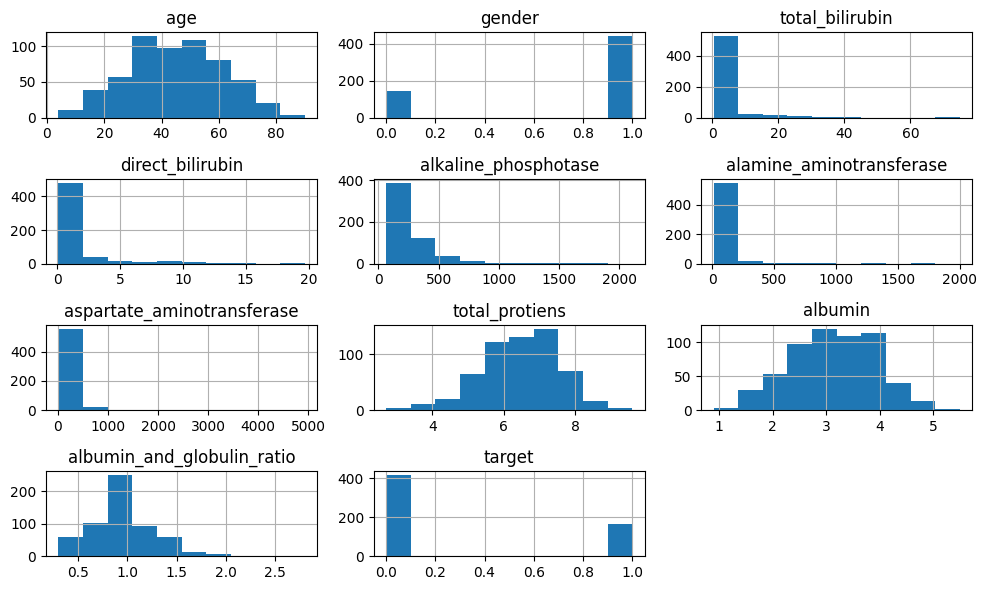

In [6]:
# histogram to understand the distibution
df.hist(figsize=(10,6))
plt.tight_layout()
plt.show()

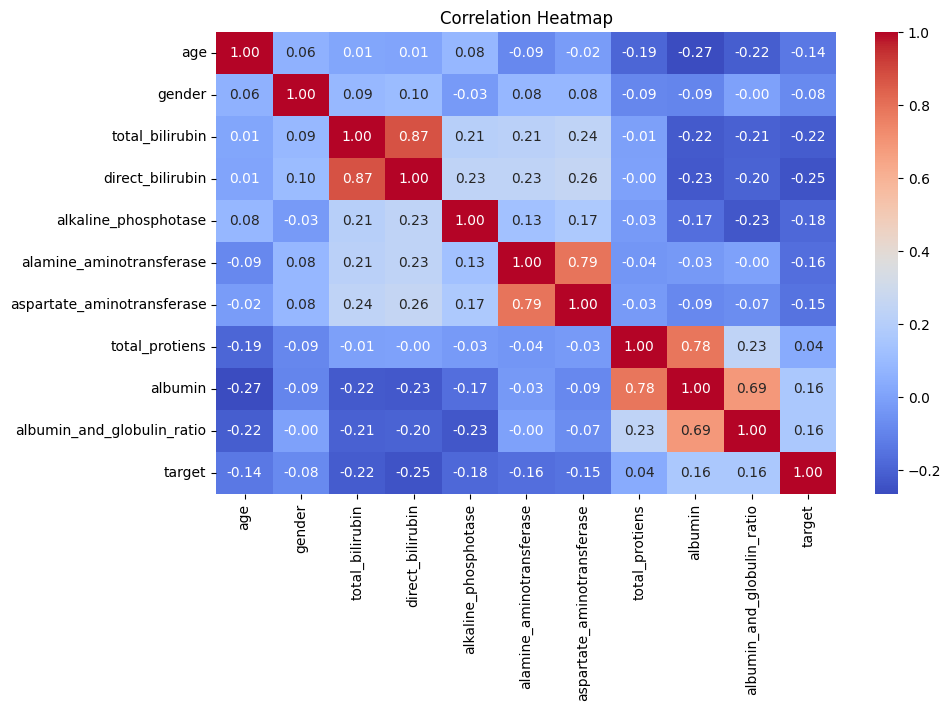

In [7]:
corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

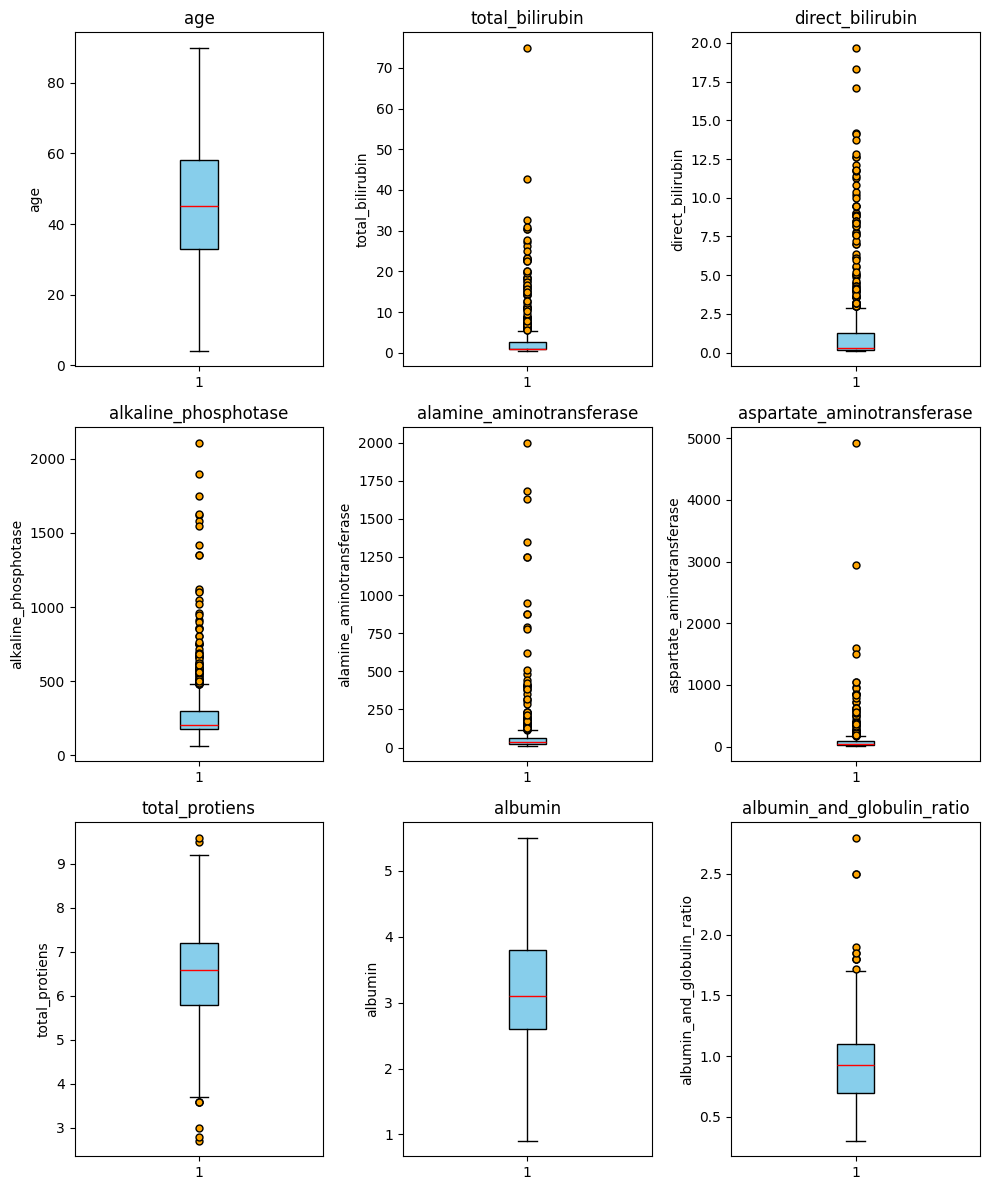

In [8]:
import matplotlib.pyplot as plt

# Define numerical columns for outlier detection
outlier_columns = [
    'age', 'total_bilirubin', 'direct_bilirubin', 'alkaline_phosphotase', 'alamine_aminotransferase', 'aspartate_aminotransferase',
    'total_protiens', 'albumin', 'albumin_and_globulin_ratio'
]

# Number of plots per row
plots_per_row = 3
total_plots = len(outlier_columns)
rows = (total_plots + plots_per_row - 1) // plots_per_row

# Set figure size
plt.figure(figsize=(10, rows * 4))

# Plot boxplots
for i, col in enumerate(outlier_columns, 1):
    plt.subplot(rows, plots_per_row, i)
    plt.boxplot(df[col].dropna(), patch_artist=True,
                boxprops=dict(facecolor='skyblue'),
                medianprops=dict(color='red'),
                whiskerprops=dict(color='black'),
                capprops=dict(color='black'),
                flierprops=dict(markerfacecolor='orange', marker='o', markersize=5))
    plt.title(col)
    plt.ylabel(col)

plt.tight_layout()
plt.show()

In [9]:
# List of features with high outliers based on your analysis
features_to_cap = [
    'total_bilirubin', 'direct_bilirubin', 'alkaline_phosphotase', 'alamine_aminotransferase', 'aspartate_aminotransferase',
    'total_protiens', 'albumin_and_globulin_ratio'
]

def cap_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Cap values outside the bounds
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    return df

# Apply capping only to specified features
for feature in features_to_cap:
    if feature in df.columns:
        print(f"Capping outliers in: {feature}")
        df = cap_outliers_iqr(df, feature)
    else:
        print(f"Feature '{feature}' not found in DataFrame.")

Capping outliers in: total_bilirubin
Capping outliers in: direct_bilirubin
Capping outliers in: alkaline_phosphotase
Capping outliers in: alamine_aminotransferase
Capping outliers in: aspartate_aminotransferase
Capping outliers in: total_protiens
Capping outliers in: albumin_and_globulin_ratio


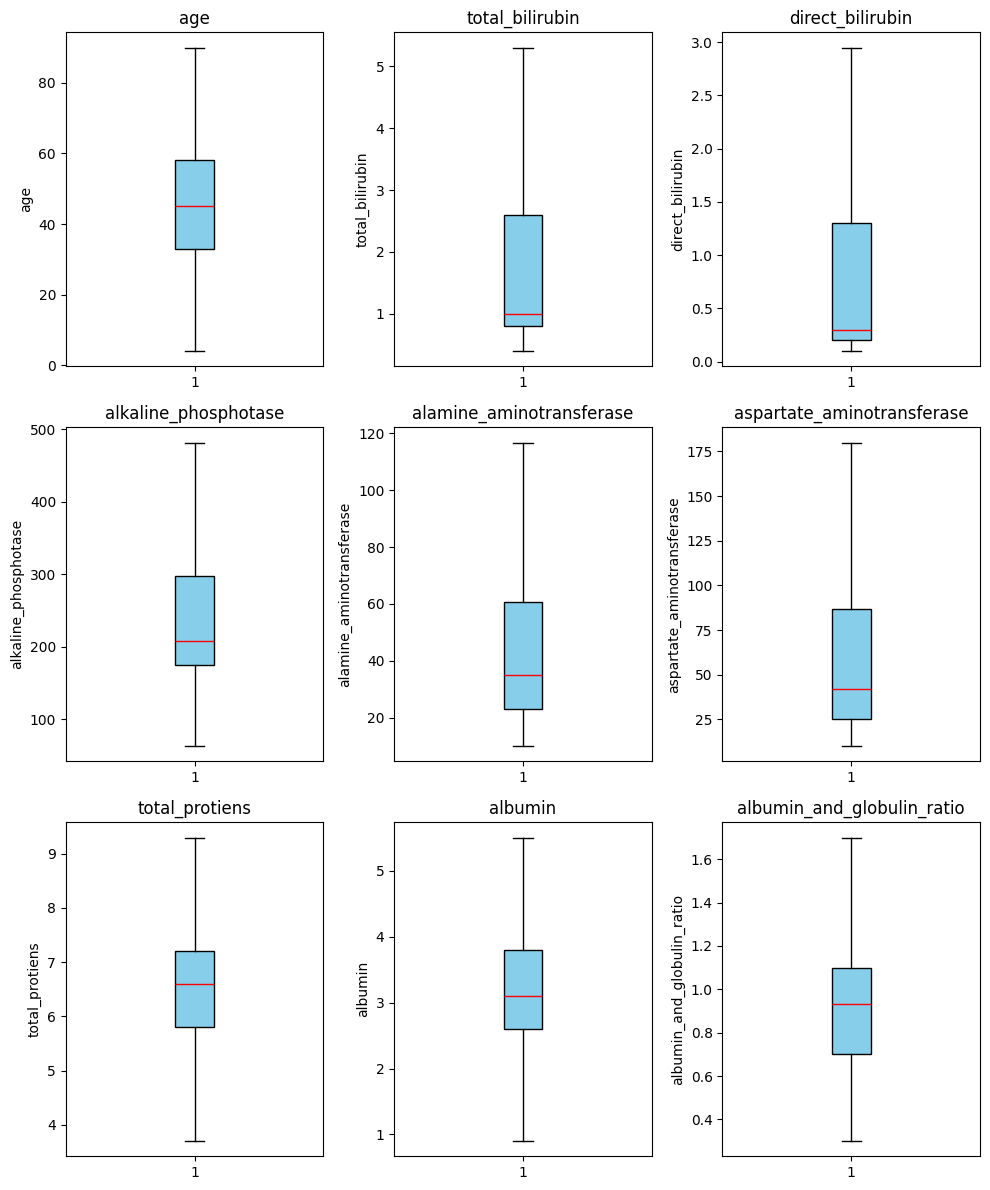

In [10]:
import matplotlib.pyplot as plt

# Define numerical columns for outlier detection
outlier_columns = [
    'age', 'total_bilirubin', 'direct_bilirubin', 'alkaline_phosphotase', 'alamine_aminotransferase', 'aspartate_aminotransferase',
    'total_protiens', 'albumin', 'albumin_and_globulin_ratio'
]

# Number of plots per row
plots_per_row = 3
total_plots = len(outlier_columns)
rows = (total_plots + plots_per_row - 1) // plots_per_row

# Set figure size
plt.figure(figsize=(10, rows * 4))

# Plot boxplots
for i, col in enumerate(outlier_columns, 1):
    plt.subplot(rows, plots_per_row, i)
    plt.boxplot(df[col].dropna(), patch_artist=True,
                boxprops=dict(facecolor='skyblue'),
                medianprops=dict(color='red'),
                whiskerprops=dict(color='black'),
                capprops=dict(color='black'),
                flierprops=dict(markerfacecolor='orange', marker='o', markersize=5))
    plt.title(col)
    plt.ylabel(col)

plt.tight_layout()
plt.show()

In [23]:
from sklearn.model_selection import  GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score


In [12]:
import sklearn
import imblearn

print("scikit-learn version:", sklearn.__version__)
print("imbalanced-learn version:", imblearn.__version__)

scikit-learn version: 1.4.2
imbalanced-learn version: 0.11.0


In [13]:
numeric_cols = ['age', 'total_bilirubin', 'direct_bilirubin', 'alkaline_phosphotase', 'alamine_aminotransferase', 'aspartate_aminotransferase', 'total_protiens', 'albumin', 'albumin_and_globulin_ratio']

# Apply StandardScaler 
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [14]:
#  Split data with stratification
x = df.drop('target', axis=1)
y = df['target']

In [15]:
print("Original class distribution:\n", y.value_counts())

Original class distribution:
 target
0.0    416
1.0    167
Name: count, dtype: int64


In [16]:
# Apply SMOTE on entire dataset

smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(x, y)

In [17]:
# Convert back to DataFrame/Series with correct columns
x_resampled = pd.DataFrame(x_resampled, columns=x.columns)
y_resampled = pd.Series(y_resampled, name='target')

In [18]:
print("Shape of X before SMOTE:", x.shape)
print("Shape of X after SMOTE :", x_resampled.shape)

print("Shape of y before SMOTE:", y.shape)
print("Shape of y after SMOTE :", y_resampled.shape)

Shape of X before SMOTE: (583, 10)
Shape of X after SMOTE : (832, 10)
Shape of y before SMOTE: (583,)
Shape of y after SMOTE : (832,)


In [19]:
# Split resampled data into training and testing sets (80% train, 20% test)
# Stratify - when you split into train/test, you still want to maintain the same ratio of classes (e.g., 50% No / 50% Yes in Attrition) in both splits.
x_train, x_test, y_train, y_test = train_test_split(
    x_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)

# Check class distribution after split
print("Train target distribution:\n", y_train.value_counts())
print("\nTest target distribution:\n", y_test.value_counts())

Train target distribution:
 target
1.0    333
0.0    332
Name: count, dtype: int64

Test target distribution:
 target
0.0    84
1.0    83
Name: count, dtype: int64


In [20]:
print("Train feature distribution:\n", x_train.shape)
print("\nTest feature distribution:\n", x_test.shape) 

Train feature distribution:
 (665, 10)

Test feature distribution:
 (167, 10)


In [21]:
# Variable	        Description
#  x	              Original scaled features
#  y	              Original target (imbalanced)
#  x_resampled	      Scaled + SMOTE-balanced features (full set)
#  y_resampled	      Balanced target labels after SMOTE
#  x_train, x_test	  Train/test features from x_resampled
#  y_train, y_test	  Train/test targets from y_resampled

Classification Report - Random Forest:

              precision    recall  f1-score   support

         0.0       0.90      0.68      0.78        84
         1.0       0.74      0.93      0.82        83

    accuracy                           0.80       167
   macro avg       0.82      0.80      0.80       167
weighted avg       0.82      0.80      0.80       167

Accuracy Score: 0.8023952095808383


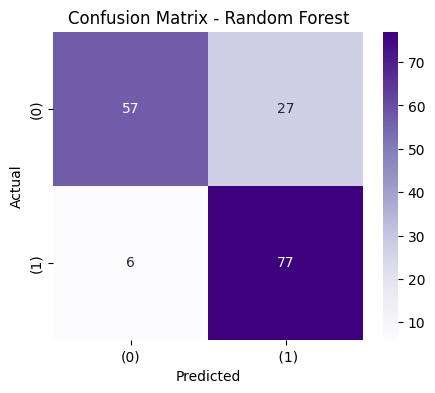

Cross-Validation Accuracy Scores: [0.82706767 0.7443609  0.7518797  0.79699248 0.87218045]
Mean CV Accuracy: 0.7984962406015038


In [25]:
# Initialize model
rfc_model = RandomForestClassifier(n_jobs=-1, n_estimators= 400, max_depth=9, class_weight='balanced', random_state=42)

# Train the model
rfc_model.fit(x_train, y_train)

# Predict
y_pred_rfc = rfc_model.predict(x_test)

# Evaluation
print("Classification Report - Random Forest:\n")
print(classification_report(y_test, y_pred_rfc))
print("Accuracy Score:", accuracy_score(y_test, y_pred_rfc))

# Confusion Matrix
cm_rfc = confusion_matrix(y_test, y_pred_rfc)
plt.figure(figsize=(5,4))
sns.heatmap(cm_rfc, annot=True, fmt="d", cmap="Purples", xticklabels=['(0)', ' (1)'], yticklabels=['(0)', '(1)'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Random Forest")
plt.show()

# 5-fold cross-validation
cv_scores_rfc = cross_val_score(rfc_model, x_train, y_train, cv=5, scoring='accuracy')
print("Cross-Validation Accuracy Scores:", cv_scores_rfc)
print("Mean CV Accuracy:", cv_scores_rfc.mean())


In [27]:
yproba = rfc_model.predict_proba(x_test)

# Step 2: Choose a threshold (default is 0.5)
threshold = 0.5  # Try 0.4 or 0.3 to improve recall for minority class

# Step 3: Convert probabilities to class labels based on threshold
y_pred_thresh = (yproba[:, 1] >= threshold).astype(int)

# Step 4: Evaluate model
print(f"Confusion Matrix (Threshold = {threshold}):\n", confusion_matrix(y_test, y_pred_thresh))
print("\nClassification Report:\n", classification_report(y_test, y_pred_thresh))
print("Accuracy Score:", accuracy_score(y_test, y_pred_thresh))

Confusion Matrix (Threshold = 0.5):
 [[57 27]
 [ 6 77]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.68      0.78        84
         1.0       0.74      0.93      0.82        83

    accuracy                           0.80       167
   macro avg       0.82      0.80      0.80       167
weighted avg       0.82      0.80      0.80       167

Accuracy Score: 0.8023952095808383


In [28]:
import pickle

# Save the scaler
with open('liver_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save the model
with open('liver_model.pkl', 'wb') as f:
    pickle.dump(rfc_model, f)

# Save the feature names (important for ordering)
with open('liver_features.pkl', 'wb') as f:
    pickle.dump(list(x_train.columns), f)